<a href="https://colab.research.google.com/github/faatihrifqi/Pascal-VOC-2007/blob/master/Pascal_VOC_2007_Faatih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the final project on DIGITALENT Machine Learning training held by KOMINFO @ Telkom University

# Deep Learning Implementation on Pascal VOC 2007 Dataset

## Overview

The purpose of this project is applying deep learning algorithm, especially transfer learning that make use of the knowledge gained while solving one problem and applying it to a different but related problem. Usually, transfer learning perform well in image and text cases. 
Pascal VOC 2007 (http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) is a collection of images and has tricky dataset, which each class may contains more than one label. It also has different image size.

## Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

np.set_printoptions(precision=7)
%matplotlib inline

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image

from PIL import Image

W0830 15:04:28.088217 140234805815168 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Load Data

The average image size of Pascal VOC 2007 is (380, 470, 3). Since we use google colab, it has maximum computational memory, so we should resize it.
**Fun fact, lower image size corresponds to lower accuracy.**

In [0]:
input_shape = (175, 175, 3) #Let's use this number for now

Let's separate the dataset into train, validation and test data and applied resize based on input shape above.

In [8]:
dataset, info = tfds.load(name="voc2007", with_info=True)		
class_names = info.features['labels'].names		
print("total class:", len(class_names))
print(class_names)

X_train = []
y_train = []
for example in tfds.as_numpy(dataset['train']):
    new_img = example['image']
    new_img = cv.resize(new_img, input_shape[:2],interpolation = cv.INTER_AREA) 
    
    y = example['labels']

    X_train.append(new_img)
    y_train.append(y)
    
train = (np.asarray(X_train),np.asarray(y_train))

print("total train data:", np.asarray(X_train).shape[0])


X_val = []
y_val = []
for example in tfds.as_numpy(dataset['validation']):
    new_img = example['image']
    new_img = cv.resize(new_img, input_shape[:2],interpolation = cv.INTER_AREA) 

    y = example['labels']
    
    X_val.append(new_img)
    y_val.append(y)
val = (np.asarray(X_val),np.asarray(y_val))

print("total validation data:", np.asarray(X_val).shape[0])

X_test = []
y_test = []
for example in tfds.as_numpy(dataset['test']):
    new_img = example['image']
    new_img = cv.resize(new_img, input_shape[:2],interpolation = cv.INTER_AREA) 

    y = example['labels']
    
    X_test.append(new_img)
    y_test.append(y)  

test = (np.asarray(X_test[:2000]),np.asarray(y_test[:2000]))
print("total test data:", np.asarray(X_test).shape[0])

del dataset

total class: 20
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
total train data: 2501
total validation data: 2510
total test data: 4952


In [0]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), class_names = train, val, test, class_names

Let's see the example image with its label

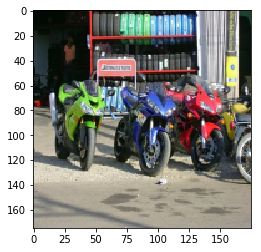

In [10]:
plt.imshow(X_train[0])

In [11]:
for i in y_train[0]:
    print(class_names[i])

motorbike
person


As shown above, the first train image data has 2 labels

## Preprocessing Data

Let's normalize the data

In [0]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

As shown above, we only have 2k images for training. Usually when we use deep learning, we want thousand of thousand data. Nicely done by keras, it provides us with ImageDataGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

datagen.fit(X_train)

Since each of image may contains more than one label (multi label), we applied MultiLabelBinarizer to them

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)
y_test = mlb.fit_transform(y_test)

## Classification Model

For simplicity, let's use pretrained model from tensorflow application (https://www.tensorflow.org/api_docs/python/tf/keras/applications), which has several model we could use (densenet, inception_resnet_v2, inception_v3, mobilenet, mobilenet_v2, nasnet, resnet50, vgg16, vgg19, xception)

I'm gonna choose VGG19 for now, we can always try different model later

In [0]:
from tensorflow.keras.applications.vgg19 import VGG19

We want the model has been trained with imagenet dataset (weights='imagenet') and we gonna define our final dense layers by ourself (include_top=False), input shape based on the shape we have defined above (input_shape=input_shape) and applied average pooling (pooling='avg')

In [16]:
model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

W0830 15:12:55.899765 140234805815168 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


80142336/80134624 [==============================] - 7s 0us/step


Let's set the trainable of the layers to False, so the weight won't update.

In [0]:
for layer in model.layers:
    layer.trainable = False  

For simplicity, I build the final layers contains of one dense layer and output layer.

In [0]:
x = model.output
x = Dense(1024, activation='relu')(x)
predictions = Dense(20, activation='sigmoid')(x)

Now, let's wrap the entire model

In [0]:
myModel = Model(inputs=model.input, outputs=predictions, name='My Model')

And this is our architecture model

In [20]:
myModel.summary()

Model: "My Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 175, 175, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 175, 175, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 175, 175, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 87, 87, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 87, 87, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 87, 87, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 43, 43, 128)       0  

## Training Time

**Adam is the best!**

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

Since we deal with multilabel and multiclass dataset, we use binary_crossentropy 

In [22]:
myModel.compile(loss='binary_crossentropy',
                        optimizer=opt, metrics=['accuracy'])

W0830 15:13:38.954406 140234805815168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


I don't want wait too long, let's us batch size 512 and epochs 10

In [0]:
batch_size = 512
epochs = 10

Finally we can fit our model

In [24]:
history = myModel.fit_generator(datagen.flow(X_train, y_train,
                                             batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    shuffle=True)

Epoch 1/10
5/5 [==============================] - 74s 15s/step - loss: 0.6964 - acc: 0.8348 - val_loss: 0.5329 - val_acc: 0.9259
Epoch 2/10
5/5 [==============================] - 21s 4s/step - loss: 0.3889 - acc: 0.9296 - val_loss: 0.3621 - val_acc: 0.9302
Epoch 3/10
5/5 [==============================] - 21s 4s/step - loss: 0.2628 - acc: 0.9364 - val_loss: 0.2511 - val_acc: 0.9417
Epoch 4/10
5/5 [==============================] - 30s 6s/step - loss: 0.1967 - acc: 0.9456 - val_loss: 0.2012 - val_acc: 0.9463
Epoch 5/10
5/5 [==============================] - 21s 4s/step - loss: 0.1581 - acc: 0.9507 - val_loss: 0.1847 - val_acc: 0.9466
Epoch 6/10
5/5 [==============================] - 21s 4s/step - loss: 0.1434 - acc: 0.9516 - val_loss: 0.1693 - val_acc: 0.9479
Epoch 7/10
5/5 [==============================] - 21s 4s/step - loss: 0.1258 - acc: 0.9569 - val_loss: 0.1529 - val_acc: 0.9521
Epoch 8/10
5/5 [==============================] - 21s 4s/step - loss: 0.1160 - acc: 0.9588 - val_loss: 

Plotting the data makes more appealing to our eyes!

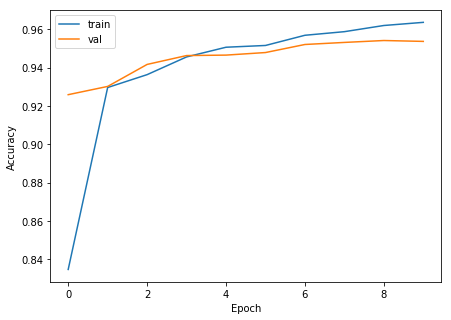

In [25]:
plt.rcParams['figure.figsize'] = [7, 5]

plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Yeay, it doesn't overfit!

How about the accuracy?

In [26]:
scores = myModel.evaluate(X_test, y_test, verbose=1)
print('Test loss    :', scores[0])
print('Test accuracy: %.2f%%' % (scores[1]*100))

2000/2000 [==============================] - 11s 5ms/sample - loss: 0.1414 - acc: 0.9539
Test loss    : 0.1414058925509453
Test accuracy: 95.39%


Not bad!

I'm not gonna end here, since we deal with classification probel, why don't we try a couple images to see how well our model is.

Just grabbing random data from the internet

In [27]:
!wget -O 'data_test_0.jpg' 'https://www.cirocapriboats.com/images/slide15.jpg'
!wget -O 'data_test_1.jpg' 'https://www.nationalgeographic.com/content/dam/news/2018/05/17/you-can-train-your-cat/02-cat-training-NationalGeographic_1484324.jpg'
!wget -O 'data_test_2.jpg' 'https://i2-prod.mirror.co.uk/incoming/article9456387.ece/ALTERNATES/s615/Holstein-dairy-cow-at-Bega-NSW.jpg'
!wget -O 'data_test_3.jpg' 'https://audubonportland.org/wp-content/uploads/2019/01/American-Robin-5D3_8701_filtered-SC-1024x682.jpg'
!wget -O 'data_test_4.jpg' 'https://www.incimages.com/uploaded_files/image/1940x900/getty_165716283_2000118020009280252_376368.jpg'

--2019-08-30 15:19:24--  https://www.cirocapriboats.com/images/slide15.jpg
Resolving www.cirocapriboats.com (www.cirocapriboats.com)... 52.20.43.245
Connecting to www.cirocapriboats.com (www.cirocapriboats.com)|52.20.43.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198878 (194K) [image/jpeg]
Saving to: ‘data_test_0.jpg’

data_test_0.jpg     100%[===================>] 194.22K   449KB/s    in 0.4s    

2019-08-30 15:19:26 (449 KB/s) - ‘data_test_0.jpg’ saved [198878/198878]

--2019-08-30 15:19:29--  https://www.nationalgeographic.com/content/dam/news/2018/05/17/you-can-train-your-cat/02-cat-training-NationalGeographic_1484324.jpg
Resolving www.nationalgeographic.com (www.nationalgeographic.com)... 104.84.156.112
Connecting to www.nationalgeographic.com (www.nationalgeographic.com)|104.84.156.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249726 (244K) [image/jpeg]
Saving to: ‘data_test_1.jpg’

data_test_1.jpg     100%[=======

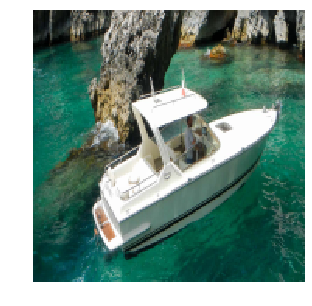

boat


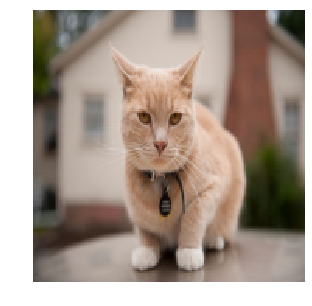

cat


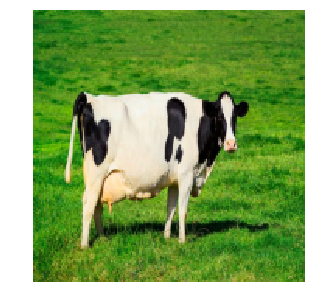

sheep


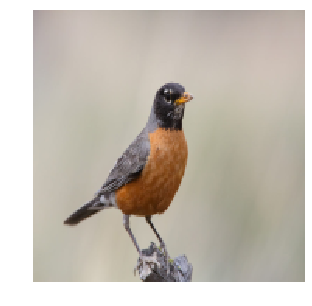

bird


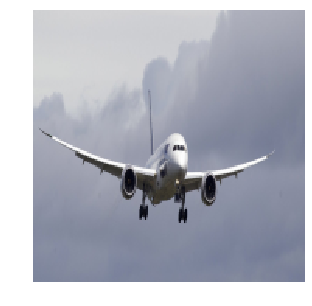

aeroplane


In [28]:
for i in range(5):
    new_img = Image.open('data_test_'+str(i)+'.jpg')
    new_img = np.array(new_img)
    new_img2 = cv.resize(new_img, input_shape[:2], interpolation=cv.INTER_AREA)
    plt.imshow(new_img2)
    plt.axis('off')
    plt.show()

    new_img2 = np.expand_dims(new_img2,0)
    pred = myModel.predict(new_img2)
    print(class_names[np.argmax(pred)])

Well, it performed as expected!